#### Annotation tool

#### Ybat - YOLO BBox Annotation Tool
- useful for object detection. Can it be used for instance segmentation?
- https://github.com/drainingsun/ybat

#### VGG Image Annotator
- useful for dataset preparation for object detection and instance segmentation
- once exported to a json file, you can read them the Python json module



In [15]:
import json

# where did I get this json file?
# it seems to be in the COCO format
via = json.load(open('labels_my-project-name_2022-02-11-12-13-39.json'))

# list of segment annotations
# one per instance
annotations = via['annotations']

first_annot = annotations[0]

# one image may have multiple or none oranges
first_annot['image_id']
first_annot['bbox']
# x_0, y_0, x_1, y_1, ... for polygons
segs = first_annot['segmentation']

#### generating makes from polygon points
- you can use scikit-image
    - `skimage.draw.polygon`
        - for a polygon annotation
    - `skimage.draw.ellipse`
        - if you have a circle or an ellipse annotation

In [26]:
import skimage


# how to get the training image size?
mask = np.zeros((480, 320), dtype=np.uint8)

for seg in segs:
    # it is for the COCO format
    rs, cs = seg[::2], seg[1::2]

    # rr and cc are row and column coordiantes of all inside pixels
    rr, cc = skimage.draw.polygon(rs, cs)
    
    mask[rr, cc] = 1

# Does the COCO format supports a circle annotation?
# to draw a circle at (cx, cy)
# rr, cc = skimage.draw.ellipse(cx, cy, r, r, shape=(160, 240))

# mask = np.zeros((160, 240), dtype=np.uint8)


#### [merging multiple VIA json files](https://github.com/Azadehkhojandi/VGG-Image-Annotator-Json-Merger)
- it might be conveninet to incrementally add training sets

### R-CNN: Region-based CNN

#### Region proposals
is a technique that helps in identifying islands of regions where the pixels are similar to one another.

#### selective search
- Region of Interests (RoI) from proposal method
- Warped regions with same size
- Fed into CNN

#### RoI align
It's like an RoI pool but an anti-aliased modification of a RoI pooling.

#### [Detecron2](https://ai.facebook.com/tools/detectron2)
- would it be quite useful for instance segmentations?

In [3]:
!ls ../data/open_images_bus_trucks

df.csv	images


In [3]:
from os import path
import numpy as np
import pandas as pd

import selectivesearch


data_dir = '../data/open_images_bus_trucks'
image_dir = 'images/images'

image_root = path.join(data_dir, image_dir)
df_raw = pd.read_csv(path.join(data_dir, 'df.csv'))

print(df_raw.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

In [4]:
from torch.utils.data import Dataset, DataLoader
from torch_snippets import *
import cv2


class OpenImages(Dataset):
    """
    This dataset gives ground truth boxes and labels
    
    Note that this dataset is not directly used for training
    For training, you need region proposals and their labels and offsets,
    which are calculated using ground truth boxes and region proposals from the selectivesearch
    """
    def __init__(self, df, image_folder=image_root):
        """
        df has one row for each ground truth box?
        """
        self.root = image_root
        self.df = df
        self.unique_images = df['ImageID'].unique()
    
    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = path.join(self.root, f'{image_id}.jpg')
        
        # another choice other than PIL.Image.open?
        image = cv2.imread(image_path, 1)[..., ::-1]
        h, w, _ = image.shape
        
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        
        # what are all XClick[\d?][XY] fields about?
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.asarray([w, h, w, h])).astype(np.uint16).tolist()
        
        classes = df['LabelName'].values.tolist()
        
        return image, boxes, classes, image_path


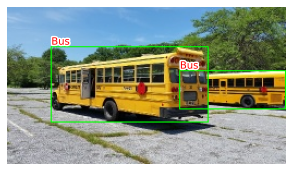

In [5]:
# OpenImages gives only ground truth boxes and labels
ds = OpenImages(df=df_raw)
im, bbs, clss, im_path = ds[11]

# ground truth boxes
# note that bbs and clss have the same length
show(im, bbs=bbs, texts=clss, th=1)

In [27]:
# every training sample has at least one ground truth box!
# Is there a particular reason not to use negative samples?
# maybe since we would more than enough negative region proposals from positive samples?
for im, bbs, clss, im_path in ds:
    if len(bbs) < 1:
        print(im_path)

#### selective search
- what are `scale` and `min_size`?

In [28]:
def extract_candidates(img):
    """
    Simple wrapper for selective search
    """
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    
    for r in regions:
        if r['rect'] in candidates:
            continue

        if r['size'] < (0.05 * img_area):
            continue

        if r['size'] > (1 * img_area):
            continue

        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))

    return candidates

#### selective region proposal example
- why this example give only 27 selectivesearch candidates?

1 ground truth box(es) ../data/open_images_bus_trucks/images/images/000817a6f6819e73.jpg


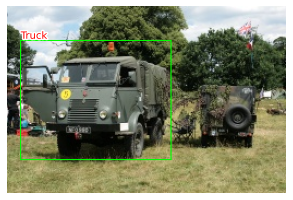

37 region proposal(s)


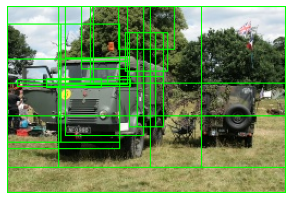

In [29]:
# ground truth boxes and labels
im, bbs, labels, fpath = ds[13]
print(len(bbs), 'ground truth box(es)', fpath)
show(im, bbs=bbs, texts=labels, th=1)

# region proposals
# we dont' know labels (or deltas) for region proposals yet
rps = extract_candidates(im)
print(len(rps), 'region proposal(s)')
show(im, bbs=rps, th=1)

In [30]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    """
    Intersection over Union between two boxes
    """
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)

    if (width < 0) or (height < 0):
        return 0.0

    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined + epsilon)

    return iou

In [31]:
# GTBBS all ground truth boxes for each training image
# IOUS IoUs for each pair of region proposal and ground truth box
# CLSS for the best IoU ground truth box
# DELTAS for the best IoU ground truth box
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500

# bbs and labels are ground truth bboxes and their labels
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix == N):
        break
    H, W, _ = im.shape
    
    # region proposals from selectivesearch for this image `im`
    candidates = extract_candidates(im)
    candidates = np.array([(x, y, x + w, y + h) for x, y, w, h in candidates])
    
    # IoUs with respect to ground truth bounding box(es)
    ious, rois, clss, deltas = [], [], [], []
    
    # `ious` shape = (# of region proposals, # of ground truth boxes)!
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    
    for jx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[jx]
        
        # which ground truth bbox give the largest IoU with this candidate?
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bbs[best_iou_at]
        
        # considered as a background with a too small IoU 
        if best_iou > 0.3:
            clss.append(labels[best_iou_at])
        else :
            clss.append('background')

        # delta is calculated even for a background region proposal
        delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
        deltas.append(delta)
        rois.append(candidate / np.array([W, H, W, H]))
    
    FPATHS.append(fpath)
    
    # ious.shape = (# of candidates, # of bbs)
    IOUS.append(ious)
    ROIS.append(rois)
    
    # clss and deltas depends on the best matching ground truth
    CLSS.append(clss)
    DELTAS.append(deltas)
    
    GTBBS.append(bbs)
    
    print(f'{ix + 1:3d} / {N:3d}', end='\r')

FPATHS = [f'{image_root}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [65]:
# for i, ious in enumerate(IOUS):
#     if ious.shape[1] > 2:
#         print(i)
#         break
print(GTBBS[6])
# DELTAS[6][0]
print('IoU:', IOUS[6][0])
print('ROIs:', ROIS[6][0])
print('CLSS:', CLSS[6][0])
print('DELTAS:', DELTAS[6][0])

# len(ROIS[6])

[[9, 39, 48, 67], [24, 30, 229, 195], [220, 52, 255, 81]]
IoU: [0.        0.1452802 0.       ]
ROIs: [0.         0.40191388 0.28515625 0.99521531]
CLSS: background
DELTAS: [ 0.09375    -0.25837321  0.609375   -0.06220096]


In [66]:
# target classes for all proposals across all images (N=500)
targets = pd.DataFrame(flatten(CLSS), columns=['label'])

# label to index
# label (str), target (int)
label2target = {l: t for t, l in enumerate(targets['label'].unique())}

# index to label
target2label = {t: l for l, t in label2target.items()}
background_class = label2target['background']

In [67]:
# VGG16 is normalized like this
# I guess ResNet share the same normalizer
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()


def decode(_y):
    _, preds = _y.max(-1)
    return preds

### RCNN implementation
- RCNN model is built from scratch
    - using vgg16 as a feature extraction layer
- two branches of custom classifier and box offset regressor

In [79]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'


class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        
        # rois, labels, deltas are same shape
        # they are for region proposals
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W, H, W, H])
        
        # `gtbbs` is not used
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        
        # bbs are proposals in pixel units
        bbs = (np.array(rois) * sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        
        # take crops from `image`
        crops = [image[y:Y, x:X] for (x, y, X, Y) in bbs]
        
        # crops are part of `image` for proposals
        # gtbbs are gound truth bounding boxes in `image` but it's not used
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    
    def collate_fn(self, batch):
        """
        this method could be static
        
        it take a batch of images and each image has a list of proposals.
        
        And this method flatten this structure.
        Thus the size of the batch is increased by the number of proposals"""
        crop_images, labels, deltas = [], [], []
        
        for ix in range(len(batch)):
            # `image` is not used here
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            
            # vgg16 takes (224, 224) shapes
            crops = [cv2.resize(crop, (224, 224)) for crop in crops]
            crops = [preprocess_image(crop / 255.)[None] for crop in crops]
            crop_images.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)

        crop_images = torch.cat(crop_images).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        
        return crop_images, labels, deltas


In [80]:
from torch.utils.data import TensorDataset, DataLoader


# 9:1 training-test ratio
n_train = 9 * len(FPATHS) // 10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [81]:
from torchvision import models


vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
    
# why did you do this?
# vgg_backbone.eval().to(device)


In [82]:
class RCNN(nn.Module):
    """
    it's a RCNN model built from scratch except that it uses a pretrained feature extraction layer
    """
    def __init__(self):
        super().__init__()
        
        # should I use vgg_backbond.classifier[0].in_features instead?
        feature_dim = 25088
        
        # all its parameters are frozen!
        self.backbone = vgg_backbone
        
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(nn.Linear(feature_dim, 512),
                                  nn.ReLU(), nn.Linear(512, 4), nn.Tanh())
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    def forward(self, input):
        feat = self.backbone(input)
        
        # two outputs from the same feature
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)

        return cls_score, bbox

    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        
        # only for non-background samples
        # is any ground truth box a background class?
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        
        self.lmb = 10.0
        
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return (detection_loss + self.lmb * regression_loss,
                    detection_loss.detach(), regression_loss.detach())
        else:
            regression_loss = 0
            return (detection_loss + self.lmb * regression_loss,
                    detection_loss.detach(), regression_loss)


In [83]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()


In [84]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()


In [85]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 1
log = Report(n_epochs)

/tmp/ipykernel_245802/28246682.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 1.000	val_loss: 2.044	val_loc_loss: 0.673	val_regr_loss: 0.137	val_acc: 0.740	(1810.70s - 0.00s remaining)))))

100%|███████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 28366.20it/s]


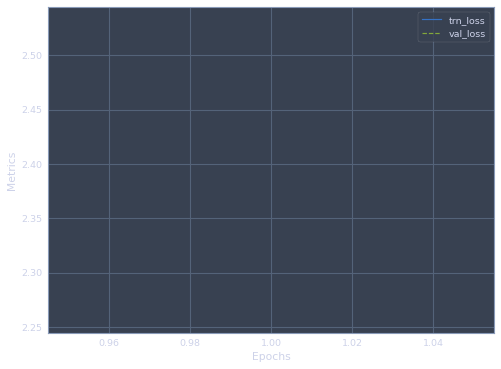

In [86]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, trn_acc=accs.mean(), end='\r')

    # validation using the test set? why?
    _n = len(test_loader)
    
    for ix, inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, rcnn, criterion)
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                   val_regr_loss=regr_loss, val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))


In [88]:
from torchvision.ops import nms


def test_predictions(filename, show_output=True):
    # selective search region proposals
    img = np.array(cv2.imread(filename, 1)[..., ::-1])
    candidates = extract_candidates(img)
    candidates = [(x, y, x + w, y + h) for x, y, w, h in candidates]
    input = []
    for candidate in candidates:
        x, y, X, Y = candidate
        crop = cv2.resize(img[y:Y, x:X], (224, 224))
        input.append(preprocess_image(crop / 255.)[None])
    input = torch.cat(input).to(device)
    
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [t.detach().cpu().numpy() for t in [confs, clss, probs, deltas]]

    # only non-background 
    ixs = clss != background_class
    confs, clss, probs, deltas, candidates = [t[ixs] for t in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    
    # non-maximum supression
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [t[ixs] for t in [confs, clss, probs, deltas, candidates, bbs]]

    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [t[None] for t in [confs, clss, probs, deltas, candidates, bbs]]
        
    if len(confs) == 0 and not show_output:
        return (0, 0, 224, 224), 'background', 0
    
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x, y, X, Y = best_bb
    
    _, ax = plt.subplots(1, 2, figsize=(20, 10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return

    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()],
         ax=ax[1], title='predicted bounding box and class', th=1)
    plt.show()
    return (x, y, X, Y), target2label[clss[best_pred]], best_conf

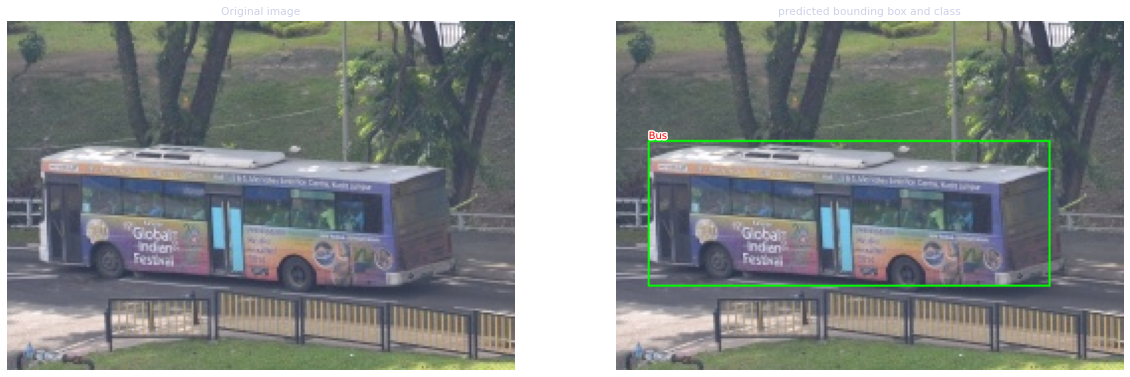

((16, 60, 218, 133), 'Bus', 0.95985305)

In [89]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)

#### just checking a test sample
- only non-background region proposals are drawn
- y is (labels, deltas)
- A classifier and a offset regressor gives pred_y = (pred_label, pred_delta)

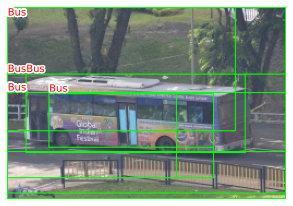

In [94]:
# image and fpath are scalars
# crops, bbs, labels, deltas, gtbbs are all same shape
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]

# among all test region proposals
# non-background indices
idx = []
# non-background labels
new_labels = []

for i, label in enumerate(labels):
    if label != 'background':
        idx.append(i)
        new_labels.append(label)

new_bbs = bbs[idx]

# non-background candidates on the test data
show(image, bbs=new_bbs, texts=new_labels, th=1)


In [265]:
!nvidia-smi

Sun Mar 13 17:31:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 62%   50C    P2    51W / 130W |   5471MiB /  6144MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [266]:
print(torch.cuda.memory_allocated(0) / 1024**3, torch.cuda.memory_reserved(0) / 1024**3)

0.9504947662353516 2.955078125


## Fast R-CNN
- this example uses `torchvision.ops.RoiPool`
    - `RoiPool` reuses features from a image for all rois for that image
- note that it still uses a selective search algorithm
    - `FRCNNDataset` stores precomputed rois for training images
    - for prediction, it needs to use the selective search algorithm for a new (unseen) image

In [24]:
class FRCNNDataset(Dataset):
    """FRCNNDataset gives additional rixs information
    """
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        """
        One difference from the collate_nf for RCNN is that
        it gives only full images (not cropped images), rois, and rixs
        since it calculates feature maps of cropped images from the feature map of a full image and
        rois and rixs!
        """
        input, rois, rixs, labels, deltas = [], [], [], [], []
        
        for ix in range(len(batch)):
            # from a items from __getitem__()
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            
            # not using torchvision.transforms.Resize?
            image = cv2.resize(image, (224, 224))
            input.append(preprocess_image(image / 255.)[None])
            
            rois.extend(image_rois)
            
            # how many roi's (or region proposals) has this image have? len(image_rois)
            # torchvision.ops.RoIPool requires this `rixs`!
            rixs.extend([ix] * len(image_rois))
            
            # labels for these rois
            labels.extend([label2target[c] for c in image_labels])
            
            deltas.extend(image_deltas)

        input = torch.cat(input).to(device)
        rois = torch.tensor(rois).float().to(device)
        rixs = torch.tensor(rixs).float().to(device)
        labels = torch.tensor(labels).long().to(device)
        # list of array -> array  -> tensor as instructed in a Torch warning message
        deltas = torch.tensor(np.asarray(deltas)).float().to(device)
        
        # (labels, deltas) are target values for the regression box
        return input, rois, rixs, labels, deltas

In [25]:
from torch.utils.data import TensorDataset, DataLoader


# 9:1 training test ratios
n_train = 9 * len(FPATHS) // 10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])


train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

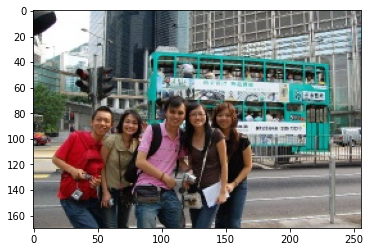

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(train_ds[0][0])

In [270]:
from torchvision.ops import RoIPool


class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # how does the batch normalization affect?
        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        for param in rawnet.features.parameters():
            param.requires_grad = True
            
        # takes vgg16_bn.features
        # except the last MaxPool2d layer
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        
        # the last layer of self.seq has the 512x14x14 output shape
        self.roipool = RoIPool(7, spatial_scale=14 / 224)
        
        # the output of the roi po0l layer
        feature_dim = 512 * 7 * 7
        
        # (1) and (2) are similar to the RCNN
        # (1) object classification
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        
        # (2) bounding box regression
        self.bbox = nn.Sequential(nn.Linear(feature_dim, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 4), nn.Tanh())
        
        # loss functions for (1) object classification and (2) bbox regressions
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    def forward(self, input, rois, ridx):
        """
        Args:
            input: shape = (# of images, 3, 224, 244) 
            rois: shape = (# of rois, 4) candidates
            ridx: shape = (# of rois,) image indices for candidates
        """
        res = input
        # res are 'conv feature map' of the original images
        # the shape of res is (512, 14, 14)
        res = self.seq(res)
        
        # note that ridx is combined with rois!
        # now, the shape of rois is (# of rois, 5)!
        rois = torch.cat([ridx.unsqueeze(-1), rois * 224], dim=-1)
        # res are now scaled crop of region proposals
        # the of res is now (512, 7, 7)
        res = self.roipool(res, rois)
        
        # flatten the feature map
        feat = res.view(len(res), -1)
        
        # (1) objectness scores, (2) bbox deltas
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
        
        return cls_score, bbox

    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        
        # include the regression loss only for non-background training region proposals
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas).detach()
#             return (detection_loss + self.lmb * regression_loss,
#                     detection_loss.detach(), regression_loss.detach())
        else:
            regression_loss = 0

        return (detection_loss + self.lmb * regression_loss,
                detection_loss.detach(), regression_loss)

In [271]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    # clss, deltas are ground truth
    # _clss, _deltas are predictions
    # `criterion` includes the box regression part too (if a predicted class is right.)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)loss.backward()
    optimizer.step()
    
    # decode transforms _clss to a one hot encoding form.
    accs = clss == decode(_clss)
    
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()


def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [272]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

EPOCH: 5.000	val_loss: 1.884	val_loc_loss: 1.111	val_regr_loss: 0.077	val_acc: 0.442	(707.07s - 0.00s remaining)))))

100%|███████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 6884.64it/s]


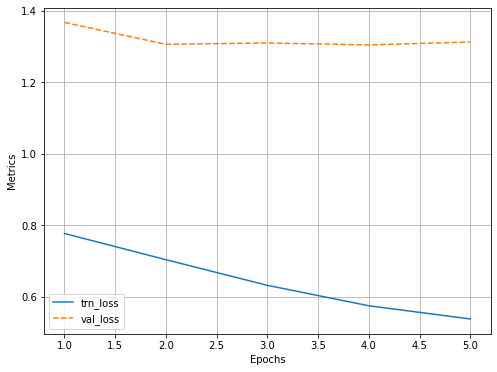

In [305]:
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
#     log.report_avgs(epoch + 1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image


def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224, 224))
    
    # selective search region proposals
    candidates = extract_candidates(img)
    candidates = [(x, y, x + w, y + h) for x, y, w, h in candidates]
    input = preprocess_image(img / 255.)[None]
    rois = [[x / 224, y / 224, X / 224, Y / 224] for x, y, X, Y in candidates]
    
    # we have only one image here. So all rixs[i] == 0!
    rixs = np.array([0] * len(rois))
    rois, rixs = [torch.tensor(item).to(device) for item in [rois, rixs]]
    
    with torch.no_grad():
        frcnn.eval()
        # frcnn takes a tensor of images, rois, and rixs
        # rixs refers to given images
        probs, deltas = frcnn(input, rois, rixs)
        
        # maximum confidence and corresponding indices
        confs, clss = torch.max(probs, -1)

    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in
                                  [confs, clss, probs, deltas]]
    
    # takes only non-background predictions
    ixs = clss != background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in
                                              [confs, clss, probs, deltas, candidates]]
    
    # bbs are predicted bounding boxes
    bbs = candidates + deltas
    
    # non-maximum suppression
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in
                                                   [confs, clss, probs, deltas, candidates, bbs]]
    
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in
                                                       [confs, clss, probs, deltas, candidates, bbs]]
    
    # plot predicted bbs and clss
    bbs = bbs.astype(np.uint16)
    
    _, (orig_ax, pred_ax) = plt.subplots(1, 2, figsize=(20, 10))
    show(img, ax=orig_ax)
    orig_ax.grid(False)
    orig_ax.set_title(filename.split('/')[-1])
    
    if len(confs) == 0:
        pred_ax.imshow(img)
        pred_ax.set_title('No objects')
        plt.show()
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=pred_ax, th=1)
        plt.show()


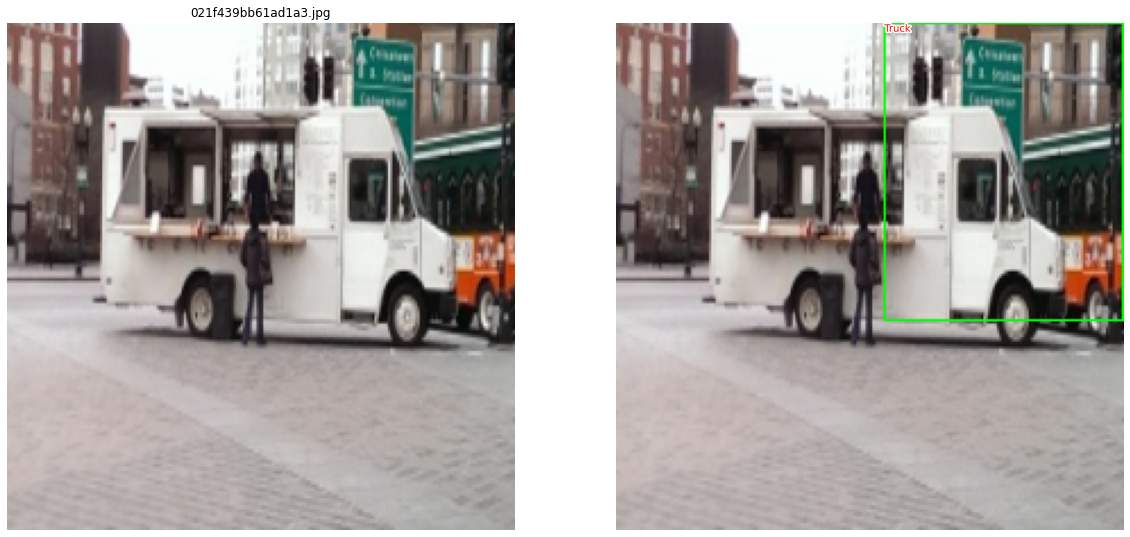

In [281]:
test_predictions(test_ds[29][-1])

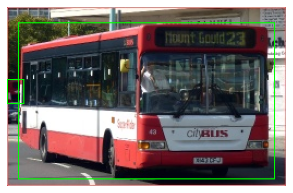

['background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'Bus', 'background', 'Bus', 'Bus', 'background', 'background', 'Bus', 'background', 'Bus', 'background', 'background', 'Bus', 'background', 'background', 'Bus', 'background', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus', 'Bus']


In [304]:
# image, rois, labels, deltas, gtbbs, fpath = test_ds[9]
# print(len(rois), len(deltas), gtbbs[0], fpath)
for image, rois, labels, deltas, gtbbs, fpath in test_ds:
    if len(gtbbs) > 1:
        show(image, bbs=gtbbs, th=1)
        print(labels)
        break


In [277]:
filename = test_ds[29][-1]


img = cv2.resize(np.array(Image.open(filename)), (224, 224))
candidates = extract_candidates(img)
candidates = [(x, y, x + w, y + h) for x, y, w, h in candidates]
input = preprocess_image(img / 255.)[None]
rois = [[x / 224, y / 224, X / 224,Y / 224] for x, y, X, Y in candidates]
rixs = np.array([0] * len(rois))
rois, rixs = [torch.tensor(item).to(device) for item in [rois, rixs]]

with torch.no_grad():
    frcnn.eval()

    # frcnn takes a tensor of rois and rixs
    probs, deltas = frcnn(input, rois, rixs)
    confs, clss = torch.max(probs, -1)

In [278]:
print(input.shape, rois.shape, rixs.shape)

torch.Size([1, 3, 224, 224]) torch.Size([34, 4]) torch.Size([34])


### Faster RCNN